In [1]:
import pandas as pd

In [3]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_data(Xs, ys, XMs = None, XIMPs = None):
    
    if XMs is not None and XIMPs is not None:
        fig, ax = plt.subplots(1, 4, figsize=(13, 2.5))
        for X, y, XM, XIMP in zip(Xs, ys, XMs, XIMPs):
            sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=y, ax=ax[0])
            missing_condition = np.isnan(XM[:, 1])
            # missing data
            sns.scatterplot(x = X[~missing_condition, 0], y = X[~missing_condition, 1], hue=y[~missing_condition], ax=ax[1])
            sns.scatterplot(x = X[missing_condition, 0], y = X[missing_condition, 1], c = 'grey', ax=ax[1])
            # imputed data
            sns.scatterplot(x = XIMP[:, 0], y = XIMP[:, 1], hue=y, ax=ax[2])
            ax[2].set_ylim(ax[0].get_ylim())
            sns.kdeplot(X[~missing_condition, 1], ax=ax[3], fill = True)
            
    elif XMs is not None and XIMPs is None:
        fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
        for X, y, XM in zip(Xs, ys, XMs):
            sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=y, ax=ax[0])
            missing_condition = np.isnan(XM[:, 1])
            sns.scatterplot(x = X[~missing_condition, 0], y = X[~missing_condition, 1], hue=y[~missing_condition], ax=ax[1])
            sns.scatterplot(x = X[missing_condition, 0], y = X[missing_condition, 1], c = 'grey', ax=ax[1])
            sns.kdeplot(X[~missing_condition, 1], ax=ax[2], fill = True)
    else:
        fig, ax = plt.subplots(1, 2, figsize=(8, 3))
        for X, y in zip(Xs, ys):
            x1 = X[:, 1].reshape(-1, 1)
            x0 = X[:, 0].reshape(-1, 1)

            sns.scatterplot(x = x0.ravel(), y = x1.ravel(), hue=y, ax=ax[0])
            sns.kdeplot(x1.ravel(), ax=ax[1], fill = True)
            
        ax[0].set_xlabel('x0')
        ax[0].set_ylabel('x1')
        ax[1].set_ylabel('Density of x1')
        plt.tight_layout()
        plt.show()
    


In [62]:
import torch.nn as nn
import torch

class Ridge(nn.Module):
    
    def __init__(self, input_dim, alpha = 0.1):
        super(Ridge, self).__init__()
        self.alpha = alpha
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)
    
    def fit(self, X, y):
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=self.alpha)
        
        for epoch in range(1000):
            inputs = torch.from_numpy(X).float()
            labels = torch.from_numpy(y).float()
            
            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print('epoch {}, loss {}'.format(epoch, loss.item()))
                
    def local_fit(self, X, y, local_epoch = 10):
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=self.alpha)
        
        for epoch in range(local_epoch):
            inputs = torch.from_numpy(X).float()
            labels = torch.from_numpy(y).float()
            
            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print('epoch {}, loss {}'.format(epoch, loss.item()))
        
        return deepcopy(self.state_dict())
    
    def update(self, params):
        self.load_state_dict(params)
                
    def predict(self, X):
        inputs = torch.from_numpy(X).float()
        return self(inputs).detach().numpy()

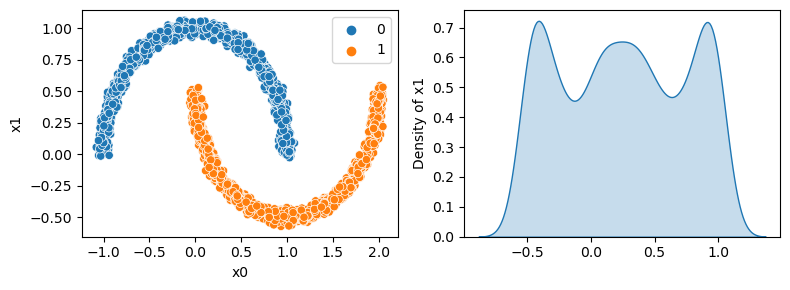

In [4]:
X, y = make_moons(n_samples=2500, noise=0.03, random_state=0)
plot_data([X], [y])

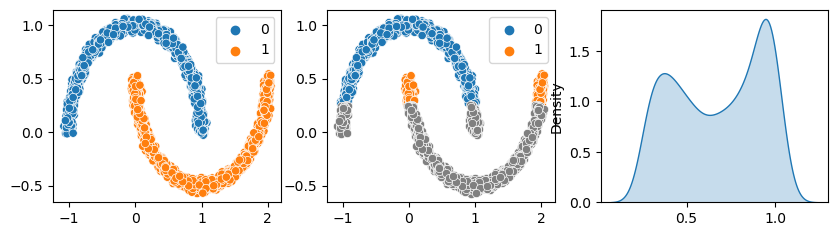

In [6]:
from copy import deepcopy


# we simulate the missing data on the second feature -> x1 (using x0 to predict x1)
def make_missing_data(X, feature_idx, q_range = (0, 0.5)):
    X_miss = deepcopy(X)
    q1 = np.quantile(X[:, feature_idx], q_range[0])
    q2 = np.quantile(X[:, feature_idx], q_range[1])
    if q_range[1] <= q_range[0]:
        X_miss[(X[:, feature_idx] <= q2) | (X[:, feature_idx] >= q1), feature_idx] = np.nan
    else:
        X_miss[(X[:, feature_idx] >= q1) & (X[:, feature_idx] <= q2), feature_idx] = np.nan
    
    return X_miss

X_miss = make_missing_data(X, 1, q_range = (0.0, 0.5))
plot_data([X], [y], [X_miss])

epoch 0, loss 0.49170029163360596
epoch 100, loss 0.19975878298282623
epoch 200, loss 0.19658270478248596
epoch 300, loss 0.19595293700695038
epoch 400, loss 0.1957753747701645
epoch 500, loss 0.1957201212644577
epoch 600, loss 0.19570226967334747
epoch 700, loss 0.1956964135169983
epoch 800, loss 0.1956944763660431
epoch 900, loss 0.19569385051727295


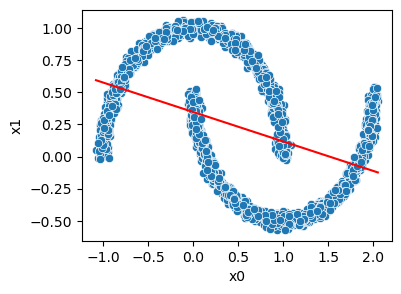

In [41]:
model = Ridge(input_dim = 1, alpha=0.1)
model.fit(X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1))
y_pred = model.predict(X[:, 0].reshape(-1, 1))

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=ax)
sns.lineplot(x = X[:, 0], y = y_pred.ravel(), color='red', ax=ax)
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

epoch 0, loss 0.8337290287017822
epoch 100, loss 0.11213929206132889
epoch 200, loss 0.09712187200784683
epoch 300, loss 0.0963473990559578
epoch 400, loss 0.09626933932304382
epoch 500, loss 0.096260204911232
epoch 600, loss 0.09625911712646484
epoch 700, loss 0.09625904262065887
epoch 800, loss 0.09625905007123947
epoch 900, loss 0.09625904262065887


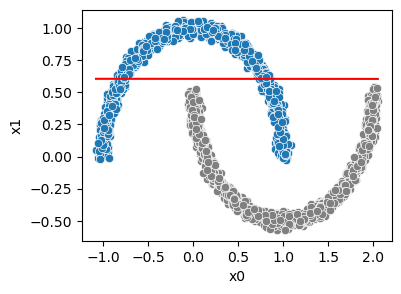

In [58]:
model1 = Ridge(input_dim = 1, alpha=0.1)
indices = np.argwhere(y == 0)
model1.fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1))
y_pred = model1.predict(X[:, 0].reshape(-1, 1))

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=ax, color = 'grey')
sns.scatterplot(x = X[indices, 0].ravel(), y = X[indices, 1].ravel(), ax=ax)
sns.lineplot(x = X[:, 0], y = y_pred.ravel(), color='red', ax=ax)
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

epoch 0, loss 3.710646390914917
epoch 100, loss 0.09878946840763092
epoch 200, loss 0.09662332385778427
epoch 300, loss 0.0959140881896019
epoch 400, loss 0.0956210121512413
epoch 500, loss 0.09549085795879364
epoch 600, loss 0.09542880207300186
epoch 700, loss 0.09539731591939926
epoch 800, loss 0.09538056701421738
epoch 900, loss 0.09537136554718018


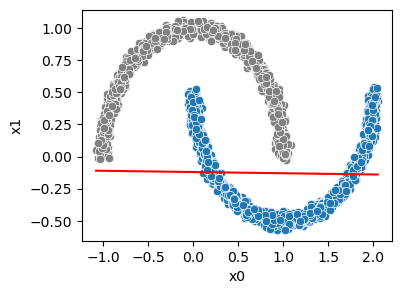

In [59]:
model2 = Ridge(input_dim = 1, alpha=0.1)
indices = np.argwhere(y == 1)
model2.fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1))
y_pred = model2.predict(X[:, 0].reshape(-1, 1))

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=ax, color = 'grey')
sns.scatterplot(x = X[indices, 0].ravel(), y = X[indices, 1].ravel(), ax=ax)
sns.lineplot(x = X[:, 0], y = y_pred.ravel(), color='red', ax=ax)
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [60]:
def fedavg(params_list):
    avg_params = deepcopy(params_list[0])
    for key, value in params_list[0].items():
        for i in range(1, len(params_list)):
            value += params_list[i][key]
        value /= len(params_list)
        avg_params[key] = value
    return avg_params

epoch 0, loss 0.39412084221839905
epoch 100, loss 0.2185685783624649
epoch 200, loss 0.19976778328418732
epoch 300, loss 0.19666260480880737
epoch 400, loss 0.19597256183624268
epoch 500, loss 0.19578123092651367
epoch 600, loss 0.19572199881076813
epoch 700, loss 0.19570288062095642
epoch 800, loss 0.1956966072320938
epoch 900, loss 0.19569455087184906
OrderedDict([('linear.weight', tensor([[-0.0003]])), ('linear.bias', tensor([0.6055]))]) OrderedDict([('linear.weight', tensor([[-0.0095]])), ('linear.bias', tensor([-0.1202]))]) OrderedDict([('linear.weight', tensor([[-0.0049]])), ('linear.bias', tensor([0.2427]))])


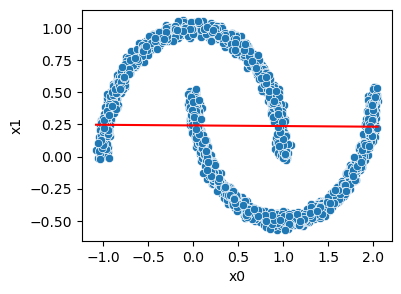

In [61]:
# one-shot averaging
model_avg = Ridge(input_dim = 1, alpha=0.1)
model_avg.fit(X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1))

avg_params = fedavg([deepcopy(model1.state_dict()), deepcopy(model2.state_dict())])
model_avg.load_state_dict(avg_params)
y_pred = model_avg.predict(X[:, 0].reshape(-1, 1))

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=ax)
sns.lineplot(x = X[:, 0], y = y_pred.ravel(), color='red', ax=ax)
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()


epoch 0, loss 1.067939043045044
epoch 0, loss 0.41561153531074524
epoch 0
epoch 0, loss 0.26148155331611633
epoch 0, loss 0.22556506097316742
epoch 1
epoch 0, loss 0.2580408751964569
epoch 0, loss 0.20972856879234314
epoch 2
epoch 0, loss 0.25410616397857666
epoch 0, loss 0.19936469197273254
epoch 3
epoch 0, loss 0.2499484419822693
epoch 0, loss 0.19260507822036743
epoch 4
epoch 0, loss 0.24577099084854126
epoch 0, loss 0.18825013935565948
epoch 5
epoch 0, loss 0.24171490967273712
epoch 0, loss 0.18551523983478546
epoch 6
epoch 0, loss 0.23787033557891846
epoch 0, loss 0.18387828767299652
epoch 7
epoch 0, loss 0.23428906500339508
epoch 0, loss 0.18298669159412384
epoch 8
epoch 0, loss 0.23099546134471893
epoch 0, loss 0.18259936571121216
epoch 9
epoch 0, loss 0.22799496352672577
epoch 0, loss 0.18254993855953217
epoch 10
epoch 0, loss 0.22528071701526642
epoch 0, loss 0.18272273242473602
epoch 11
epoch 0, loss 0.2228381633758545
epoch 0, loss 0.1830371767282486
epoch 12
epoch 0, loss 0

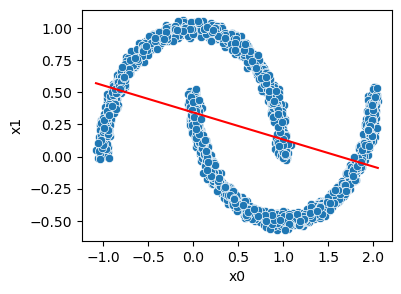

In [63]:
# sdg averaging
local_epoch = 10
model1 = Ridge(input_dim = 1, alpha=0.1)
model2 = Ridge(input_dim = 1, alpha=0.1)

global_epoch = 100

for epoch in range(global_epoch):
    indices = np.argwhere(y == 0)
    params1 = model1.local_fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1), local_epoch)
    indices = np.argwhere(y == 1)
    params2 = model2.local_fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1), local_epoch)
    
    avg_params = fedavg([deepcopy(params1), deepcopy(params2)])
    model1.update(avg_params)
    model2.update(avg_params)
    print('epoch {}'.format(epoch))

model_avg = Ridge(input_dim = 1, alpha=0.1)
model_avg.load_state_dict(avg_params)

y_pred = model_avg.predict(X[:, 0].reshape(-1, 1))
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=ax)
sns.lineplot(x = X[:, 0], y = y_pred.ravel(), color='red', ax=ax)
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()



Text(0, 0.5, 'Probability of y=1')

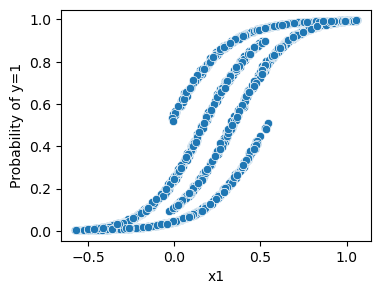

In [93]:
from sklearn.linear_model import LogisticRegressionCV
indices = np.argwhere(y == 0)
mask = y == 0

mm_model = LogisticRegressionCV(cv=5, Cs = [1], random_state=0)
mm_model.fit(X, mask.ravel())

miss_prob = mm_model.predict_proba(X)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 1], y = miss_prob[:, 1], ax=ax)
plt.xlabel('x1')
plt.ylabel('Probability of y=1')

epoch 0, loss 0.1832909733057022
epoch 0, loss 0.11037929356098175
epoch 0
epoch 0, loss 0.21215637028217316
epoch 0, loss 0.4053722620010376
epoch 1
epoch 0, loss 0.21983535587787628
epoch 0, loss 0.32550567388534546
epoch 2
epoch 0, loss 0.22569255530834198
epoch 0, loss 0.27523481845855713
epoch 3
epoch 0, loss 0.22949431836605072
epoch 0, loss 0.2431015819311142
epoch 4
epoch 0, loss 0.23148803412914276
epoch 0, loss 0.22229520976543427
epoch 5
epoch 0, loss 0.2320667952299118
epoch 0, loss 0.20869633555412292
epoch 6
epoch 0, loss 0.23162108659744263
epoch 0, loss 0.19976605474948883
epoch 7
epoch 0, loss 0.23048286139965057
epoch 0, loss 0.1939084827899933
epoch 8
epoch 0, loss 0.22891220450401306
epoch 0, loss 0.19010064005851746
epoch 9
epoch 0, loss 0.22710251808166504
epoch 0, loss 0.18767410516738892
epoch 10
epoch 0, loss 0.22519174218177795
epoch 0, loss 0.18618479371070862
epoch 11
epoch 0, loss 0.2232743203639984
epoch 0, loss 0.18533293902873993
epoch 12
epoch 0, loss 0

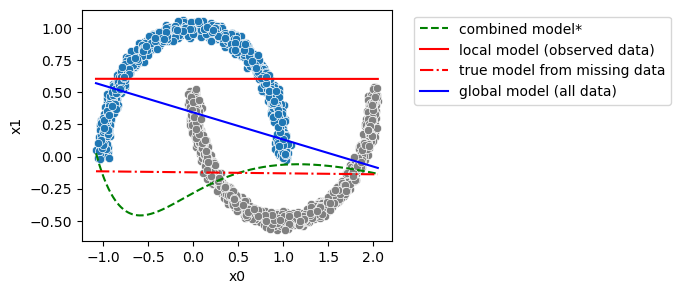

In [112]:
# mixing of local and global model

local_epoch = 10
model1 = Ridge(input_dim = 1, alpha=0.1)
model2 = Ridge(input_dim = 1, alpha=0.1)

global_epoch = 100

for epoch in range(global_epoch):
    indices = np.argwhere(y == 0)
    params1 = model1.local_fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1), local_epoch)
    indices = np.argwhere(y == 1)
    params2 = model2.local_fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1), local_epoch)
    
    avg_params = fedavg([deepcopy(params1), deepcopy(params2)])
    model1.update(avg_params)
    model2.update(avg_params)
    print('epoch {}'.format(epoch))

model_avg = Ridge(input_dim = 1, alpha=0.1)
model_avg.load_state_dict(avg_params)

y_pred_g = model_avg.predict(X[:, 0].reshape(-1, 1))

model1 = Ridge(input_dim = 1, alpha=0.1)
model2 = Ridge(input_dim = 1, alpha=0.1)
indices = np.argwhere(y == 0)
model1.fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1))
indices = np.argwhere(y == 1)
model2.fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1))
y_pred_m1 = model1.predict(X[:, 0].reshape(-1, 1))
y_pred_m2 = model2.predict(X[:, 0].reshape(-1, 1))

# mm_model
mask = y == 0
mm_model1 = LogisticRegressionCV(cv=5, Cs = [0.1], random_state=0, class_weight='balanced')
mm_model1.fit(X[:, 0].reshape(-1, 1), mask.ravel())
miss_prob1 = mm_model1.predict_proba(X[:, 0].reshape(-1, 1))[:, 1]

mask = y == 1
mm_model2 = LogisticRegressionCV(cv=5, Cs = [0.1], random_state=0, class_weight='balanced')
mm_model2.fit(X[:, 0].reshape(-1, 1), mask.ravel())
miss_prob2 = mm_model2.predict_proba(X[:, 0].reshape(-1, 1))[:, 1]

y_pred_m1_new = y_pred_g.ravel() * (1/miss_prob2)  -  y_pred_m1.ravel() * (1 - miss_prob2)/miss_prob2
y_pred_m2_new = y_pred_g.ravel() * (1/miss_prob1)  -  y_pred_m2.ravel() * (1 - miss_prob1)/miss_prob1

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=ax, color = 'grey')
indices = np.argwhere(y == 0)
sns.scatterplot(x = X[indices, 0].ravel(), y = X[indices, 1].ravel(), ax=ax)
sns.lineplot(x = X[:, 0], y = y_pred_m1_new.ravel(), color='green', ax=ax, linestyle='--', label='combined model*')
sns.lineplot(x = X[:, 0], y = y_pred_m1.ravel(), color='red', ax=ax, linestyle='-', label = 'local model (observed data)')
#sns.lineplot(x = X[:, 0], y = y_pred_m2_new.ravel(), color='green', ax=ax, linestyle='--')
sns.lineplot(x = X[:, 0], y = y_pred_m2.ravel(), color='red', ax=ax, linestyle='-.', label = 'true model from missing data')
sns.lineplot(x = X[:, 0], y = y_pred_g.ravel(), color='blue', ax=ax, label='global model (all data)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

epoch 0, loss 2.1983304023742676
epoch 0, loss 1.653921127319336
epoch 0
epoch 0, loss 0.7797912955284119
epoch 0, loss 0.524526059627533
epoch 1
epoch 0, loss 0.6981486678123474
epoch 0, loss 0.4084893763065338
epoch 2
epoch 0, loss 0.6279577016830444
epoch 0, loss 0.33142387866973877
epoch 3
epoch 0, loss 0.5675176978111267
epoch 0, loss 0.2795625627040863
epoch 4
epoch 0, loss 0.5155289173126221
epoch 0, loss 0.24432384967803955
epoch 5
epoch 0, loss 0.47090229392051697
epoch 0, loss 0.2202487587928772
epoch 6
epoch 0, loss 0.4326806664466858
epoch 0, loss 0.20379233360290527
epoch 7
epoch 0, loss 0.4000083804130554
epoch 0, loss 0.19260570406913757
epoch 8
epoch 0, loss 0.37212109565734863
epoch 0, loss 0.18510301411151886
epoch 9
epoch 0, loss 0.34834060072898865
epoch 0, loss 0.18019478023052216
epoch 10
epoch 0, loss 0.32807061076164246
epoch 0, loss 0.17712129652500153
epoch 11
epoch 0, loss 0.3107917308807373
epoch 0, loss 0.1753460019826889
epoch 12
epoch 0, loss 0.2960551381

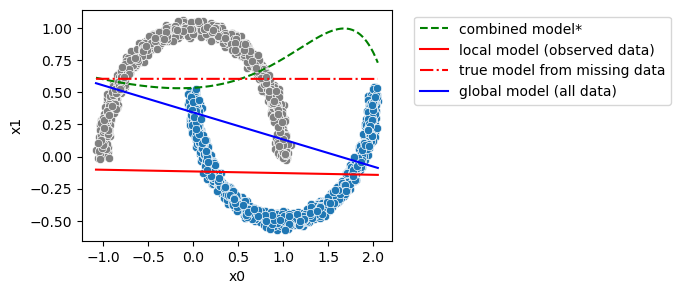

In [114]:
# mixing of local and global model

local_epoch = 10
model1 = Ridge(input_dim = 1, alpha=0.1)
model2 = Ridge(input_dim = 1, alpha=0.1)

global_epoch = 100

for epoch in range(global_epoch):
    indices = np.argwhere(y == 0)
    params1 = model1.local_fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1), local_epoch)
    indices = np.argwhere(y == 1)
    params2 = model2.local_fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1), local_epoch)
    
    avg_params = fedavg([deepcopy(params1), deepcopy(params2)])
    model1.update(avg_params)
    model2.update(avg_params)
    print('epoch {}'.format(epoch))

model_avg = Ridge(input_dim = 1, alpha=0.1)
model_avg.load_state_dict(avg_params)

y_pred_g = model_avg.predict(X[:, 0].reshape(-1, 1))

model1 = Ridge(input_dim = 1, alpha=0.1)
model2 = Ridge(input_dim = 1, alpha=0.1)
indices = np.argwhere(y == 0)
model1.fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1))
indices = np.argwhere(y == 1)
model2.fit(X[indices, 0].reshape(-1, 1), X[indices, 1].reshape(-1, 1))
y_pred_m1 = model1.predict(X[:, 0].reshape(-1, 1))
y_pred_m2 = model2.predict(X[:, 0].reshape(-1, 1))

# mm_model
mask = y == 0
mm_model1 = LogisticRegressionCV(cv=5, Cs = [0.1], random_state=0, class_weight='balanced')
mm_model1.fit(X[:, 0].reshape(-1, 1), mask.ravel())
miss_prob1 = mm_model1.predict_proba(X[:, 0].reshape(-1, 1))[:, 1]

mask = y == 1
mm_model2 = LogisticRegressionCV(cv=5, Cs = [0.1], random_state=0, class_weight='balanced')
mm_model2.fit(X[:, 0].reshape(-1, 1), mask.ravel())
miss_prob2 = mm_model2.predict_proba(X[:, 0].reshape(-1, 1))[:, 1]

y_pred_m1_new = y_pred_g.ravel() * (1/miss_prob2)  -  y_pred_m1.ravel() * (1 - miss_prob2)/miss_prob2
y_pred_m2_new = y_pred_g.ravel() * (1/miss_prob1)  -  y_pred_m2.ravel() * (1 - miss_prob1)/miss_prob1

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=ax, color = 'grey')
indices = np.argwhere(y == 1)
sns.scatterplot(x = X[indices, 0].ravel(), y = X[indices, 1].ravel(), ax=ax)
sns.lineplot(x = X[:, 0], y = y_pred_m2_new.ravel(), color='green', ax=ax, linestyle='--', label='combined model*')
sns.lineplot(x = X[:, 0], y = y_pred_m2.ravel(), color='red', ax=ax, linestyle='-', label = 'local model (observed data)')
#sns.lineplot(x = X[:, 0], y = y_pred_m2_new.ravel(), color='green', ax=ax, linestyle='--')
sns.lineplot(x = X[:, 0], y = y_pred_m1.ravel(), color='red', ax=ax, linestyle='-.', label = 'true model from missing data')
sns.lineplot(x = X[:, 0], y = y_pred_g.ravel(), color='blue', ax=ax, label='global model (all data)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()